# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers

#!pip install scikit-plot
import scikitplot as skplt

# Download [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

37 clases de perros y gatos con aproximadamente 200 imágenes por clase. 7393 imágenes en total.

### 1) Download images

In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -O - | tar -xz

--2021-09-22 13:01:32--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
SSL_INIT
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Conectando con www.robots.ox.ac.uk (www.robots.ox.ac.uk)[129.67.94.2]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 791918971 (755M) [application/x-gzip]
Grabando a: «STDOUT»

-                   100%[===================>] 755,23M  7,89MB/s    en 85s     

2021-09-22 13:02:57 (8,92 MB/s) - escritos a stdout [791918971/791918971]



In [2]:
!ls images | wc -l

7393


### 2) Download labels

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -O - | tar -xz

--2021-09-22 13:03:39--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
SSL_INIT
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Conectando con www.robots.ox.ac.uk (www.robots.ox.ac.uk)[129.67.94.2]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 19173078 (18M) [application/x-gzip]
Grabando a: «STDOUT»

-                   100%[===================>]  18,28M  5,71MB/s    en 3,5s    

2021-09-22 13:03:43 (5,28 MB/s) - escritos a stdout [19173078/19173078]



In [9]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


# Create pandas Dataframe

In [2]:
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog

train = pd.read_csv("annotations/trainval.txt", sep=' ', names=["Imagen", "RazaPG", "Animal", "Raza"])
test  = pd.read_csv("annotations/test.txt", sep=' ', names=["Imagen", "RazaPG", "Animal", "Raza"])

train["Animal"].replace({1: "Gato", 2: "Perro"}, inplace=True)
test["Animal"].replace({1: "Gato", 2: "Perro"}, inplace=True)

train["Raza"] = train.Imagen.str.replace('\d+', '', regex=True).str[:-1]
test["Raza"]  = test.Imagen.str.replace('\d+', '', regex=True).str[:-1]

train["Imagen"] = train.Imagen + ".jpg"
test["Imagen"]  = test.Imagen + ".jpg"

train.drop(columns=['RazaPG'], inplace=True)
test.drop(columns=['RazaPG'], inplace=True)

print("Train:", len(train), "Test:", len(test))
train.sample(10)

Train: 3680 Test: 3669


,Imagen,Animal,Raza
3415,shiba_inu_183.jpg,Perro,shiba_inu
3251,saint_bernard_164.jpg,Perro,saint_bernard
862,japanese_chin_115.jpg,Perro,japanese_chin
1926,american_bulldog_184.jpg,Perro,american_bulldog
175,basset_hound_123.jpg,Perro,basset_hound
855,japanese_chin_109.jpg,Perro,japanese_chin
365,Bombay_114.jpg,Gato,Bombay
299,Bengal_145.jpg,Gato,Bengal
3133,Ragdoll_155.jpg,Gato,Ragdoll
1295,pug_146.jpg,Perro,pug


# Usar solo los perros

In [3]:
ANIMAL = "Perro"

train = train[train.Animal == ANIMAL]
test  = test[test.Animal == ANIMAL]

NUM_RAZAS = train.Raza.nunique()

print("Hay",NUM_RAZAS,"razas distintas de",ANIMAL)

Hay 25 razas distintas de Perro


In [4]:
train.Raza.value_counts()

american_bulldog              100
american_pit_bull_terrier     100
wheaten_terrier               100
staffordshire_bull_terrier    100
shiba_inu                     100
scottish_terrier              100
samoyed                       100
saint_bernard                 100
pug                           100
pomeranian                    100
miniature_pinscher            100
leonberger                    100
keeshond                      100
japanese_chin                 100
havanese                      100
great_pyrenees                100
german_shorthaired            100
english_setter                100
chihuahua                     100
boxer                         100
beagle                        100
basset_hound                  100
yorkshire_terrier             100
newfoundland                   96
english_cocker_spaniel         96
Name: Raza, dtype: int64

# Keras dataset

In [5]:
#datagen = ImageDataGenerator(rescale=1./255.)
resnet50_prepro = keras.applications.resnet50.preprocess_input
datagen = ImageDataGenerator(preprocessing_function=resnet50_prepro)

IMG_SIZE = 120

train_ds = datagen.flow_from_dataframe(dataframe=train,
                                                 directory="./images",
                                                 x_col='Imagen',
                                                 y_col="Raza",
                                                 batch_size=32,
                                                 seed=42,
                                                 shuffle=True,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 class_mode='categorical')
                                                  
test_ds = datagen.flow_from_dataframe(dataframe=test,
                                              directory="./images",
                                              x_col='Imagen',
                                              y_col="Raza",
                                              batch_size=100,
                                              seed=42,
                                              shuffle=False,
                                              target_size=(IMG_SIZE,IMG_SIZE),
                                              class_mode='categorical')

Found 2492 validated image filenames belonging to 25 classes.
Found 2486 validated image filenames belonging to 25 classes.


# Create custom model (no es habitual)

In [6]:
"""
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_RAZAS, activation='sigmoid'))
model.compile(optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()
""";

# Retrain existing pretrained model (Transfer leraning)

In [8]:
######### BODY MODEL: PRETRAINED RESNET
input_t = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
model_body = keras.applications.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)
######### FREEZE LAYERS
for layer in model_body.layers[:143]:
    layer.trainable = False
    

######### ADD CUSTOM HEAD
model = keras.models.Sequential()
model.add(model_body)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(NUM_RAZAS, activation='softmax'))


model.compile(optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy", # binary_crossentropy
              metrics=["accuracy"])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                819225    
Total params: 24,406,937
Trainable params: 15,795,225
Non-trainable params: 8,611,712
_________________________________________________________________


In [10]:
model.fit(x=train_ds,
          validation_data=test_ds,
          epochs=5 # callbacks=callbacks
)

2021-09-23 14:10:28.617038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-09-23 14:10:32.215645: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


78/78 [==============================] - 16s 146ms/step - loss: 3.7044 - accuracy: 0.5285 - val_loss: 996.4261 - val_accuracy: 0.1327
Epoch 2/5
78/78 [==============================] - 9s 115ms/step - loss: 1.0909 - accuracy: 0.9089 - val_loss: 90.6772 - val_accuracy: 0.4449
Epoch 3/5
78/78 [==============================] - 9s 115ms/step - loss: 0.8473 - accuracy: 0.9543 - val_loss: 5.2151 - val_accuracy: 0.5969
Epoch 4/5
78/78 [==============================] - 9s 115ms/step - loss: 0.4375 - accuracy: 0.9599 - val_loss: 2.5013 - val_accuracy: 0.6344
Epoch 5/5
78/78 [==============================] - 9s 114ms/step - loss: 0.2915 - accuracy: 0.9791 - val_loss: 2.7095 - val_accuracy: 0.6295


# Predict test data

<BarContainer object of 25 artists>

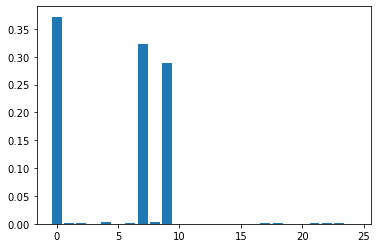

In [11]:
test_ds[0][1], 

p = model.predict(test_ds[0][0])

plt.bar(np.arange(0,25), p[0])

In [13]:
preds_probabilities = model.predict(test_ds)
preds_probabilities.shape

(2486, 25)

In [14]:
preds = preds_probabilities.argmax(axis=1)
preds.shape

(2486,)

In [15]:
train_ds.class_indices

{'american_bulldog': 0,
 'american_pit_bull_terrier': 1,
 'basset_hound': 2,
 'beagle': 3,
 'boxer': 4,
 'chihuahua': 5,
 'english_cocker_spaniel': 6,
 'english_setter': 7,
 'german_shorthaired': 8,
 'great_pyrenees': 9,
 'havanese': 10,
 'japanese_chin': 11,
 'keeshond': 12,
 'leonberger': 13,
 'miniature_pinscher': 14,
 'newfoundland': 15,
 'pomeranian': 16,
 'pug': 17,
 'saint_bernard': 18,
 'samoyed': 19,
 'scottish_terrier': 20,
 'shiba_inu': 21,
 'staffordshire_bull_terrier': 22,
 'wheaten_terrier': 23,
 'yorkshire_terrier': 24}

In [21]:
map_list = list(preds)
map_fn   = {v: k for k, v in train_ds.class_indices.items()}.get
preds_name = np.array(list(map(map_fn, map_list)))
preds_name

array(['american_bulldog', 'american_bulldog', 'american_bulldog', ...,
       'yorkshire_terrier', 'keeshond', 'havanese'], dtype='<U26')

In [22]:
reals_name = test.Raza.values
reals_name

array(['american_bulldog', 'american_bulldog', 'american_bulldog', ...,
       'yorkshire_terrier', 'yorkshire_terrier', 'yorkshire_terrier'],
      dtype=object)

In [24]:
( preds_name == reals_name ).sum() / len(preds)

0.6295253419147224

# Confussion matrix

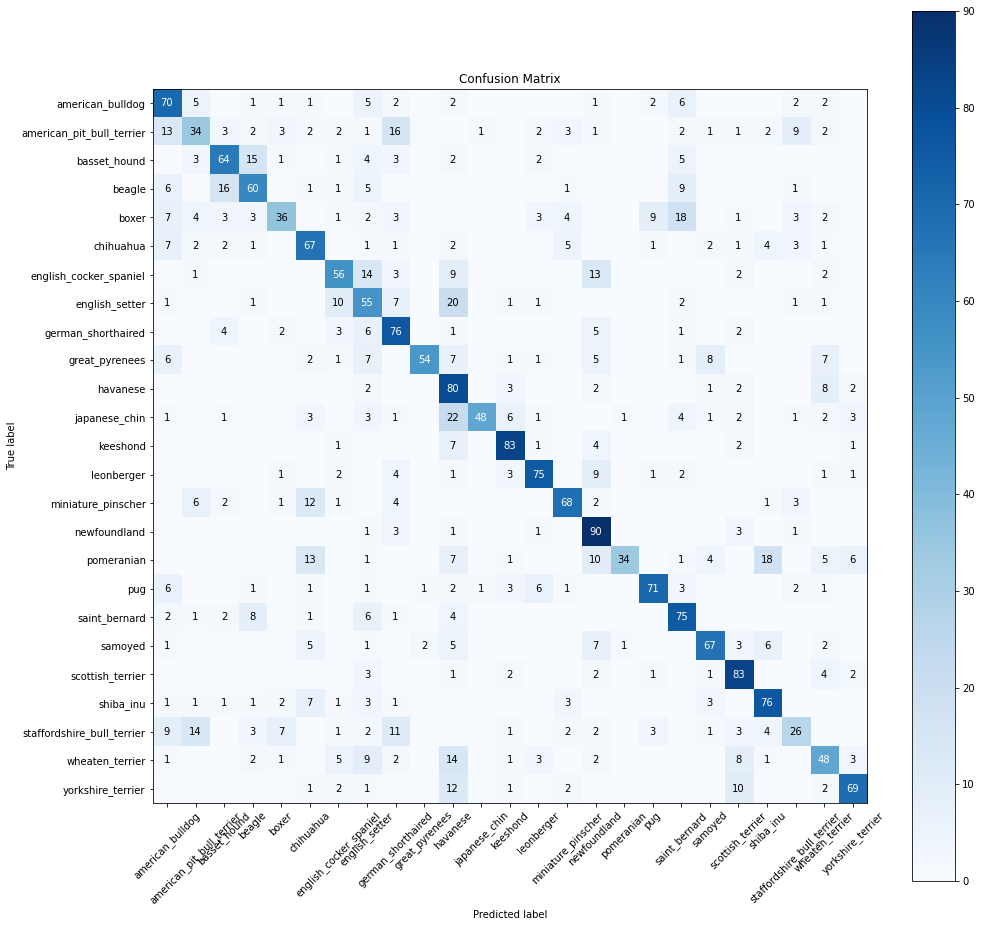

In [33]:
skplt.metrics.plot_confusion_matrix(y_true = reals_name,
                                    y_pred = preds_name,
                                    normalize = False,
                                    hide_zeros = True,
                                    figsize = (16,16),
                                    x_tick_rotation = 45);